In [ ]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [ ]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=30

In [ ]:
dataset=tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/Colab Notebooks/skin_train",
                                                    shuffle=True,
                                                   image_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                   batch_size=BATCH_SIZE)

Found 2874 files belonging to 8 classes.


In [ ]:
class_names =dataset.class_names
class_names

['Acne and Rosacea Photos',
 'Actinic Keratosis  Carcinoma and Malignant Lesions',
 'Bullous Disease Photos',
 'Cellulitis Impetigo and Bacterial Infections',
 'Hair Loss Photos Alopecia and other Hair Diseases',
 'Nail Fungus and other Nail Disease',
 'Poison Ivy Photos and other Contact Dermatitis',
 'Vasculitis Photos']

In [ ]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(image_batch.numpy())

(32, 256, 256, 3)
[[[[105.95477    134.95477    166.95477   ]
   [114.1051     143.1051     175.1051    ]
   [120.56299    149.56299    183.56299   ]
   ...
   [  3.           8.          14.        ]
   [  3.           8.          14.        ]
   [  3.           8.          14.        ]]

  [[ 93.95093    122.95093    154.95093   ]
   [121.95044    150.95044    182.95044   ]
   [115.14807    144.14807    176.14807   ]
   ...
   [  3.           8.          14.        ]
   [  3.           8.          14.        ]
   [  3.           8.          14.        ]]

  [[121.96301    150.96301    182.96301   ]
   [122.342896   151.3429     183.3429    ]
   [124.06445    153.06445    185.06445   ]
   ...
   [  3.           8.          14.        ]
   [  3.           8.          14.        ]
   [  3.           8.          14.        ]]

  ...

  [[  3.           8.          14.        ]
   [  3.1417847    7.8582153   14.        ]
   [  4.           7.          14.        ]
   ...
   [ 11.074219   

In [ ]:
plt.figure(figsize=(20,15))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
len(dataset)

90

In [ ]:
def get_dataset_partition_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert(train_split+test_split+val_split) ==1
    ds_size =len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size =int(train_split*ds_size)
    val_size =int(val_split*ds_size)
    train_ds =ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [ ]:
train_ds,val_ds,test_ds=get_dataset_partition_tf(dataset)

In [ ]:
len(train_ds)

72

In [ ]:
len(val_ds)

9

In [ ]:
train_ds =train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds =val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds =test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy()/255)

[[[0.53789157 0.40063667 0.37710726]
  [0.5460832  0.40882832 0.39314204]
  [0.5404579  0.40320304 0.38751677]
  ...
  [0.49684292 0.35958803 0.3517449 ]
  [0.50703126 0.3708793  0.36413908]
  [0.50007993 0.3667466  0.36282504]]

 [[0.52639925 0.38130122 0.3577718 ]
  [0.54010415 0.40284926 0.3849571 ]
  [0.52681863 0.3895637  0.37387744]
  ...
  [0.49803922 0.3647059  0.35686275]
  [0.49773332 0.3644     0.3576598 ]
  [0.49695158 0.36361825 0.3596967 ]]

 [[0.51691175 0.3718137  0.34044117]
  [0.5376182  0.3925202  0.3667849 ]
  [0.52572715 0.38847226 0.372786  ]
  ...
  [0.49382564 0.36681268 0.35686275]
  [0.4862745  0.3647059  0.3540441 ]
  [0.48526347 0.36369485 0.3558517 ]]

 ...

 [[0.5870864  0.46551776 0.45375305]
  [0.5987329  0.47152698 0.44628188]
  [0.5668893  0.4374775  0.40218338]
  ...
  [0.6657241  0.49317506 0.49292997]
  [0.65734196 0.4797684  0.49043018]
  [0.65744483 0.47742033 0.4763174 ]]

 [[0.57790047 0.4484887  0.42888087]
  [0.5869011  0.45748937 0.43224427]


In [ ]:
resize_and_rescale =tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
data_augmentation =tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
input_shape =(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=8
model=models.Sequential([resize_and_rescale,
                  data_augmentation,
                  layers.Conv2D(16,kernel_size=(3,3),activation='relu',input_shape=input_shape),
                  layers.MaxPooling2D((2,2)),
                  #layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
                  #layers.MaxPooling2D((2,2)),
                  #layers.Conv2D(128,kernel_size=(3,3),activation='relu'),
                  #layers.MaxPooling2D((2,2)),
                  layers.Conv2D(32,(3,3),activation='relu'),
                  layers.MaxPooling2D((2,2)),
                  layers.Conv2D(64,(3,3),activation='relu'),
                  layers.MaxPooling2D((2,2)),

                  layers.Conv2D(128,(3,3),activation='relu'),
                  layers.MaxPooling2D((2,2)),


                  layers.Flatten(),
                  layers.Dense(256,activation='relu'),
                  layers.Dense(n_classes,activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 32)          0         
 g2D)                                                 

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history= model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/30
72/72 [==============================] - 3s 45ms/step - loss: 0.1952 - accuracy: 0.9401 - val_loss: 0.8546 - val_accuracy: 0.8646
Epoch 2/30
72/72 [==============================] - 3s 44ms/step - loss: 0.1908 - accuracy: 0.9371 - val_loss: 0.9785 - val_accuracy: 0.8646
Epoch 3/30
72/72 [==============================] - 3s 44ms/step - loss: 0.2646 - accuracy: 0.9041 - val_loss: 0.5655 - val_accuracy: 0.8681
Epoch 4/30
72/72 [==============================] - 3s 44ms/step - loss: 0.1723 - accuracy: 0.9397 - val_loss: 0.4418 - val_accuracy: 0.9167
Epoch 5/30
72/72 [==============================] - 3s 49ms/step - loss: 0.1995 - accuracy: 0.9340 - val_loss: 0.9074 - val_accuracy: 0.8646
Epoch 6/30
72/72 [==============================] - 3s 45ms/step - loss: 0.2442 - accuracy: 0.9175 - val_loss: 0.7216 - val_accuracy: 0.8542
Epoch 7/30
72/72 [==============================] - 3s 44ms/step - loss: 0.2191 - accuracy: 0.9297 - val_loss: 0.6247 - val_accuracy: 0.8819
Epoch 8/30
72

In [ ]:
model.save("New.h5")

SyntaxError: ignored

In [ ]:
scores = model.evaluate(test_ds)

9/9 [==============================] - 10s 20ms/step - loss: 1.2240 - accuracy: 0.5799


In [ ]:
history.history['accuracy']

[0.1875,
 0.2860243022441864,
 0.3285590410232544,
 0.3298611044883728,
 0.3784722089767456,
 0.3893229067325592,
 0.4075520932674408,
 0.4227430522441864,
 0.4292534589767456,
 0.4340277910232544,
 0.453125,
 0.4748263955116272,
 0.4696180522441864,
 0.4904513955116272,
 0.4769965410232544,
 0.4917534589767456,
 0.51171875,
 0.5286458134651184,
 0.5308159589767456,
 0.5295138955116272,
 0.5616319179534912,
 0.5572916865348816,
 0.5464409589767456,
 0.5815972089767456,
 0.5824652910232544,
 0.6028645634651184,
 0.5920138955116272,
 0.5872395634651184,
 0.6028645634651184,
 0.6375868320465088]

In [ ]:
acc=history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss = history.history['val_loss']

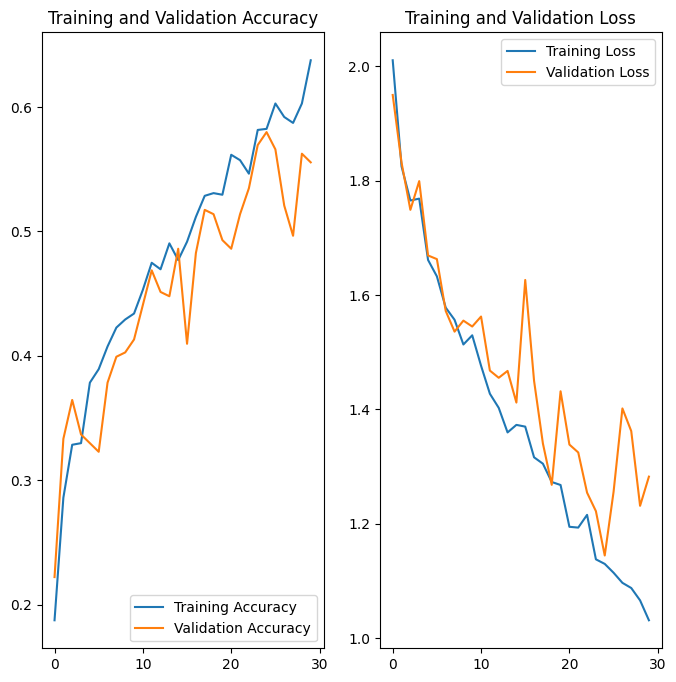

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Nail Fungus and other Nail Disease
1/1 [==============================] - 0s 41ms/step
predicted label: Nail Fungus and other Nail Disease


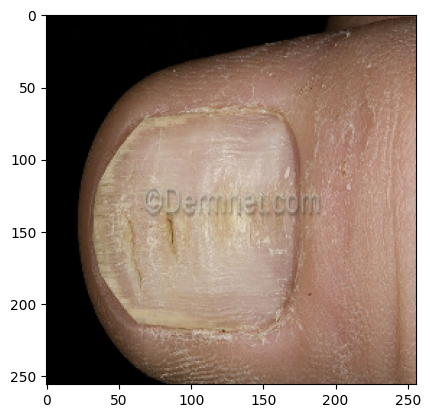

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])


In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(20, 20))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.